In [1]:
from google.colab import files
uploaded = files.upload()  # Upload image1.jpg and image2.jpg
from google.colab import files
uploaded = files.upload()  # Upload image1.jpg and image2.jpg

Saving cv 1.jpg to cv 1.jpg


Saving cv2.jpg to cv2.jpg


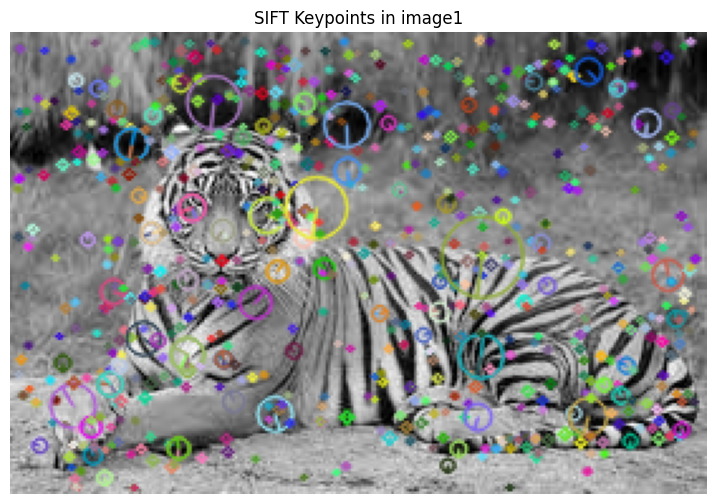

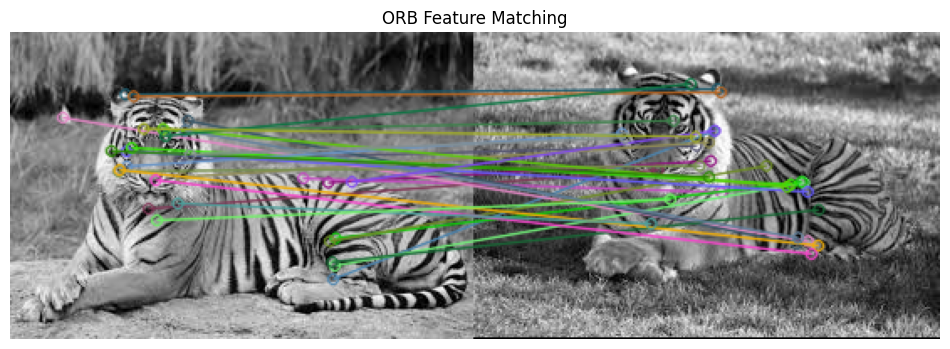

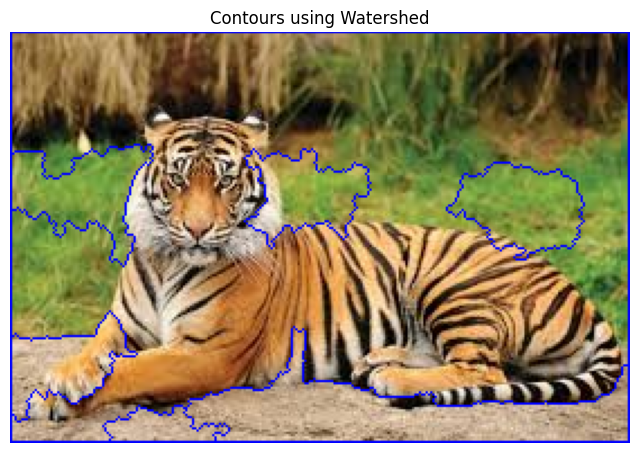

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load images ###
img1 = cv2.imread('cv1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('cv2.jpg', cv2.IMREAD_GRAYSCALE)

# Check if loaded
if img1 is None or img2 is None:
    raise FileNotFoundError("Check if image1.jpg and image2.jpg are uploaded properly.")

###############################
### Part 1: SIFT Detection ###
###############################

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

img_sift = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,6))
plt.title("SIFT Keypoints in image1")
plt.imshow(img_sift, cmap='gray')
plt.axis('off')
plt.show()

##################################
### Part 2: ORB + BFMatcher ###
##################################

orb = cv2.ORB_create()
kp3, des3 = orb.detectAndCompute(img1, None)
kp4, des4 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des3, des4)
matches = sorted(matches, key=lambda x: x.distance)

img_match = cv2.drawMatches(img1, kp3, img2, kp4, matches[:30], None, flags=2)

plt.figure(figsize=(12, 6))
plt.title("ORB Feature Matching")
plt.imshow(img_match)
plt.axis('off')
plt.show()

########################################
### Part 3: Contour Detection ###
########################################

# Load color image for contour
img_color = cv2.imread('cv1.jpg')
if img_color is None:
    raise FileNotFoundError("image1.jpg failed to load.")

gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
markers = cv2.watershed(img_color, markers)
img_color[markers == -1] = [255, 0, 0]  # Mark borders in red

plt.figure(figsize=(8, 6))
plt.title("Contours using Watershed")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3251 - val_loss: 0.1792
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1710 - val_loss: 0.1542
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1519 - val_loss: 0.1424
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1422 - val_loss: 0.1360
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1356 - val_loss: 0.1316
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1312 - val_loss: 0.1278
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1281 - val_loss: 0.1249
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1251 - val_loss: 0.1231
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1231 - val_loss: 0.1218
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1214 - val_loss: 0.1199
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


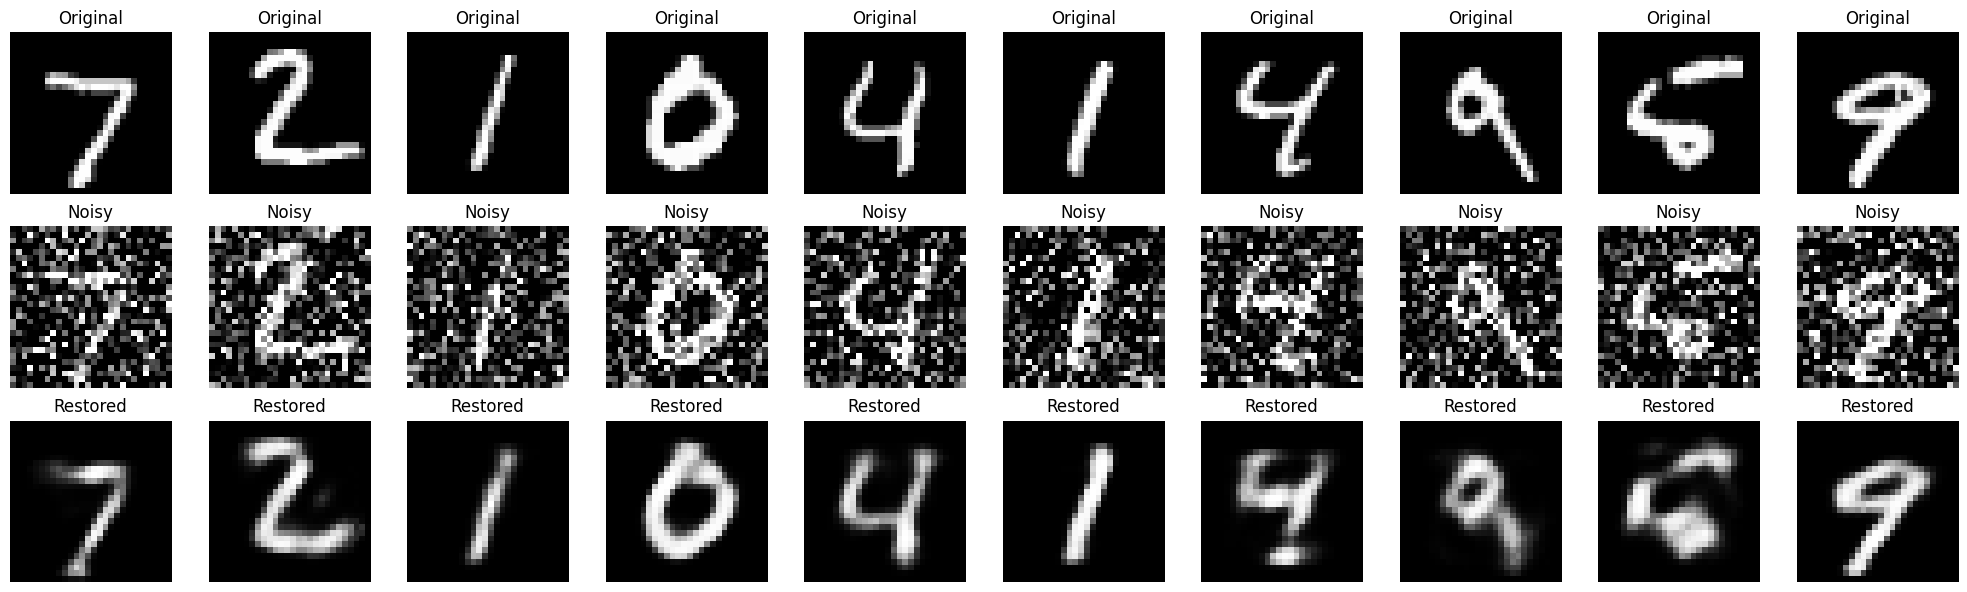

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

# 1. Load and preprocess MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 2. Add Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# 3. Build autoencoder model
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 4. Train the model
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# 5. Predict denoised images
restored_imgs = autoencoder.predict(x_test_noisy)

# 6. Plot original, noisy, and restored images
n = 10  # how many digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Restored
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(restored_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Restored")
    plt.axis('off')

plt.tight_layout()
plt.show()